In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

olivetti_faces = fetch_openml("olivetti_faces", as_frame=False ,parser='auto')
X, y = olivetti_faces.data, olivetti_faces.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=40, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=80, stratify=y_train, random_state=43)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
print(pca.n_components_)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)
199


In [20]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.9375

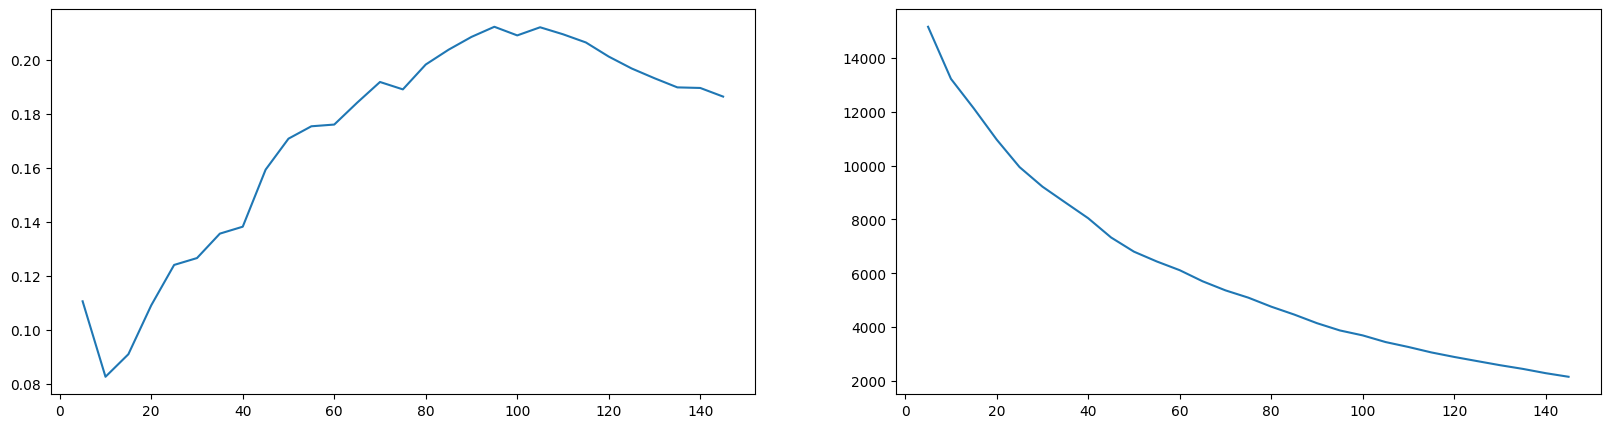

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
inertia_scores = []
kmeans_per_k = []
k_range = range(5, 150, 5)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=42)
    kmeans.fit(X_train_pca)
    kmeans_per_k.append(kmeans)

silhouette_scores = [silhouette_score(X_train_pca, model.labels_) for model in kmeans_per_k]
inertia_scores = [model.inertia_ for model in kmeans_per_k]
    
figure, (axis1, axis2) = plt.subplots(1, 2, figsize=(20, 5)) 
axis1.plot([i for i in k_range], silhouette_scores)
axis2.plot([i for i in k_range], inertia_scores )
plt.show()

In [22]:
best_index = np.argmax(silhouette_scores)
k_range = range(5, 150, 5)
best_k = k_range[best_index]
best_model = kmeans_per_k[best_index]
labels = best_model.fit_predict(X_train_pca)
print(best_index, best_k, best_model)

18 95 KMeans(n_clusters=95, n_init='auto', random_state=42)


In [24]:
X_train_reduced = best_model.transform(X_train_pca)
X_val_reduced = best_model.transform(X_val_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf_reduced = RandomForestClassifier(n_estimators=150, random_state=42)
clf_reduced.fit(X_train_reduced, y_train)
clf_reduced.score(X_val_reduced, y_val)

0.775

In [26]:
from sklearn.pipeline import make_pipeline

for n_clusters in k_range:
    pipeline = make_pipeline(
        KMeans(n_clusters=n_clusters, n_init='auto', random_state=42),
        RandomForestClassifier(n_estimators=150, random_state=42)
    )
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_val_pca, y_val))

5 0.5125
10 0.525
15 0.6625
20 0.7625
25 0.7125
30 0.7875
35 0.7875
40 0.775
45 0.7875
50 0.7875
55 0.8
60 0.8
65 0.775
70 0.775
75 0.7875
80 0.725
85 0.775
90 0.7375
95 0.775
100 0.7875
105 0.7375
110 0.7625
115 0.8125
120 0.775
125 0.7625
130 0.825
135 0.8125
140 0.7625
145 0.75


In [27]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_val_extended = np.c_[X_val_pca, X_val_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

clf_extended = RandomForestClassifier(n_estimators=150, random_state=42)
clf_extended.fit(X_train_extended, y_train)
clf_extended.score(X_val_extended, y_val)
print("")

0.8125